# Character Level RNN using LSTM cells.

- Trains on Star Trek episode titles
- Outputs "fake" titles.

Much comes from a [Keras example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py).

## Setup Environment

- Import Keras
- Open up the Star Trek corpus
- We need to translate the textual data into a format that the RNN can accept as input.
- Give each letter an index and create dictionaries to translate from index to character.

In [1]:
## Much borrowed from https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model

from keras.callbacks import LambdaCallback
import numpy as np
import random
import sys

#Helper method sampling and generating text from an RNN after training
from SamplingAndGeneratingText import generate_text_segment

text = open("startrekepisodes.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
vocabulary_size = len(chars)
print('total chars:', vocabulary_size)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


# How long is a title?
titles = text.split('\n')
lengths = np.array([len(n) for n in titles])
print("Max:", np.max(lengths))
print("Mean:", np.mean(lengths))
print("Median:", np.median(lengths))
print("Min:", np.min(lengths))

# hence choose 30 as seuence length to train on.
print("Character Dictionary: ", char_indices)
print("Inverse Character Dictionary: ", indices_char)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


corpus length: 11010
total chars: 49
Max: 50
Mean: 14.001362397820163
Median: 13.0
Min: 2
Character Dictionary:  {'n': 33, 'v': 41, 'h': 27, '.': 8, 'y': 44, 'f': 25, 'a': 20, '-': 7, '\n': 0, 'é': 47, 'e': 24, 't': 39, '4': 13, ' ': 1, 'g': 26, 'p': 35, 'j': 29, '9': 17, 'd': 23, '2': 11, '5': 14, 'z': 45, 'i': 28, '1': 10, 'x': 43, ')': 5, '3': 12, 'q': 36, '0': 9, '(': 4, 'r': 37, '?': 19, 'o': 34, ':': 18, '8': 16, 'b': 21, 'l': 31, '’': 48, 'u': 40, 's': 38, '!': 2, 'à': 46, 'c': 22, 'w': 42, ',': 6, 'k': 30, '7': 15, 'm': 32, "'": 3}
Inverse Character Dictionary:  {0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '7', 16: '8', 17: '9', 18: ':', 19: '?', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'k', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'q', 37: 'r', 38: 's', 39: 't', 40: 'u', 41: 'v', 42: 'w', 43: 'x', 44: 'y', 45: 'z', 46: 'à', 47: 'é',

## Setup Training Data

- Cut up the corpus into semi-redundant sequences of 30 characters.
- Change indices into "one-hot" vector encodings.

<img src="figures/slicing_text.png",width=600>

In [2]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 30
step = 3

sentences = [] #The training data
next_chars = [] #The training labels

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

print(sentences[0])
print(next_chars[0])

nb sequences: 3660
the man trap
charlie x
where n
o


### Onehot encoding:
* a -> [1, 0, 0, ..., 0]
* b -> [0, 1, 0, ..., 0]
* ...

Each training sample becomes 2D tensor:
* "This is the text" -> X = [[0, 0, ..., 1, 0, ..., 0], ..., [0, 0, ..., 1, 0, ... 0]]

Each target (next letter) becomes 1D onehot tensor:
* a -> y = [1, 0, 0, ..., 0]

In [3]:
#X shape: 3D tensor. First dimension is the sentences, second is each letter in each sentence, third is the onehot
#vector representing that letter.
X = np.zeros((len(sentences), maxlen, vocabulary_size), dtype=np.bool)
y = np.zeros((len(sentences), vocabulary_size), dtype=np.bool)
    
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print("Done preparing training corpus, shapes of sets are:")
print("X shape: " + str(X.shape))
print("y shape: " + str(y.shape))
print("Vocabulary of characters:", vocabulary_size)

Done preparing training corpus, shapes of sets are:
X shape: (3660, 30, 49)
y shape: (3660, 49)
Vocabulary of characters: 49


## Model

- Model has one hidden layer of 128 LSTM cells.
- Output layer uses the "softmax" activation function to output a probability distribution over next letters.

<img src="figures/n-in-1-out.png",width=800>

In [4]:
layer_size = 128
model_train = Sequential()
model_train.add(LSTM(layer_size, input_shape=(maxlen, len(chars))))
# Project back to vocabulary. One output node for each letter.
# Dense indicates a fully connected layer.
# Softmax activation ensures the combined values of all outputs form a probability distribution:
# They sum to 1, with each individual value between 0 and 1.
model_train.add(Dense(len(chars), activation='softmax'))

In [5]:
# Categorical crossentropy  minimizes the distance between the probability distributions 
# output by the network and the true distribution of the targets.
# The optimizer specifies HOW the gradient of the loss will be used to update parameters.
# Different optimizers have different tricks to avoid local optima, etc.
# RMSProp is adaptive, adjusting the rate of learning to how fast we're currently learning.
model_train.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
model_train.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               91136     
_________________________________________________________________
dense_1 (Dense)              (None, 49)                6321      
Total params: 97,457
Trainable params: 97,457
Non-trainable params: 0
_________________________________________________________________


## Training

- Train on batches of 128 examples

In [6]:
#Callback, which starts some text generation after each epoch.
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    diversity = 0.5 #Can be modified to change the amount of creativity in the network

    generated = generate_text_segment(text, 400, diversity, model_train,
                                      maxlen, len(chars), char_indices, indices_char)
    sys.stdout.write(generated)
    print()

In [8]:
# Training the Model. history captures data for plotting (e.g loss)
print("training start")
#Setting up a callback, which will generate example text from the network during training.
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history = model_train.fit(X, y, batch_size=128, epochs=20, verbose=0, callbacks=[print_callback])
print("Training done")

training start

----- Generating text after Epoch: 0
----- Generating with seed: "endgame
broken bow
fight or fl"endgame
broken bow
fight or flion
the aethe hous of the prishidy
trount
yive angertion
artiss ald swalo, alterios
aro, al on ontes of thi stheng
mingerill home splre of lathe, part two
f antion
the searcite songallore
the beath
the eomenind
droun bliont
fition
edone of fivion
the jourl the porstuent fe of the pirrontwadon
the couss ince foitht of angerede
doghont ang alo
s are thele of fivion
the beat of mathe
the akd gime of 

----- Generating text after Epoch: 1
----- Generating with seed: "tion
death wish
lifesigns
acce"tion
death wish
lifesigns
acces im way
dous stive
in tae the parst woll gatho
wersssald
the emind
tiey the astigy ars shall sinateesterder re ung on alb
ithe the plart lolbon
the conga blyeat of anceve
seace, part i
le since the vear
the enfect fear
herke sthire of the vear
yous ant ol the parssin
the styrmenter
roge atter of inte
cousses
lat imen machine 

In [9]:
# Save model if necessary
model_train.save("keras-startrek-LSTM-model.h5")

## Plotting training error

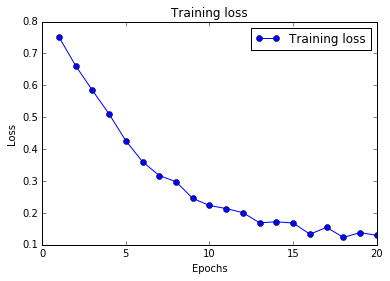

In [10]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b-o', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()